This notebook will explore models for element identification in a LIBS spectra
The model will not estimate abundance, but rather provide a filter for subsequent fitting
For example, a L-S fit of the indicated elemental atomic spectra to the composite input spectra yields abundance
Note the the unequal intensity of pure atomic spectra indicates a non-equal weighting needed in L-S step

While this may ultimately be implemented in pytorch as a custom model (and would be a good exercise), there
are off the shelf libraries for this task available in sklearn that provide a straightforward starting point
and benchmark for further improvement, such as BP-MLL (Zhang/Zhou 2006)

In [2]:
#imports
import pickle
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
##COMMENT OUT FOR NON-INTEL PROCESSOR
#from sklearnex import patch_sklearn
#patch_sklearn()
###
from libs_unet.training.spec_maker import spectrum_maker

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import jaccard_score

import plotly.graph_objects as go

top_dir = Path.cwd()
datapath = top_dir / 'data'

#constants
eps = 1e-6
nist_mult = 1.168

In [3]:
#data import
with open(datapath / 'training' / 'el80_pairs_lg.pickle', 'rb') as f:
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

Multilabel classification
The relevant library appears to be sklearn.multiclass.OneVsRestClassifier
with the target y set to a (sample x classes) array of binary class indicators
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

In [4]:
#prep data for multilabel classification
#x array will be the intensities (potentially scaled / transformed) by wavelength
#y array will be the binary indcators of element presence - e.g. length 80 array of 0/1s

#prediction accuracy only ~5% without log transform
x_scaled = nist_mult * x_data
X = np.log(x_scaled + eps) # (9560, 782)
y = (fracs > 0).astype('int') # (9560, 80)

#make a little modification to allow stratified splitting
# The first 80 samples are single-element and do not recur
# each "label" has to appear at least twice for stratification
# tack copy of first 80 x,y to end of each

X = np.append(X, X[:80], axis=0)
y = np.append(y, y[:80], axis=0)
#split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
    stratify=y, random_state=42)

In [5]:
#check stratification, looking at pct samples "positive" for each element
train_pcts = np.sum(y_train, axis=0) / len(y_train)
print(f"training labels, min:{np.min(train_pcts)} max: {np.max(train_pcts)}")

test_pcts = np.sum(y_test, axis=0) / len(y_test)
print(f"test labels, min:{np.min(test_pcts)} max: {np.max(test_pcts)}")


training labels, min:0.024475524475524476 max: 0.025407925407925407
test labels, min:0.023496503496503496 max: 0.026293706293706295


In [6]:
# Train classifier
#Notes on choice of estimator for labeled classifiction indicates LinearSVC for <100k sample, else SGDClassifier
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
#SVC was 1m 40s for 9,560 samples. Linear SVC took 10m 26s and did not converge
clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)

In [7]:
#review predictions for test set
y_pred = clf.predict(X_test)

In [8]:
#prediction accuracy, all labels exact
hits = 0
for i in range(len(y_pred)):
     if np.array_equal(y_pred[i], y_test[i]):
        hits +=1
print(f"prediction accuracy: {hits / len(y_pred)}")
#accuracy 46.4% for log transformed x
#accuracy 5.18% for non-transformed x
#accuracy 5.6% for log.log transformed x


prediction accuracy: 0.6843356643356643


In [118]:
#Look at Jaccard scores which gives partial credit
#https://scikit-learn.org/stable/modules/model_evaluation.html#jaccard-similarity-score
samp_avg_jacc = jaccard_score(y_test, y_pred, average='samples') # % correct by sample, then averaged
print(f"sample average acc: {samp_avg_jacc}")
elem_jacc = np.round(jaccard_score(y_test, y_pred, average=None),4)

fig = go.Figure(data=[go.Table(header=dict(values=['Element', 'Prediction Accuracy']),
                 cells=dict(values=[elem_symb, elem_jacc]))])
fig.update_layout(width=500, height=2000)
fig.show()

sample average acc: 0.8421445221445222


In [119]:
#check accuracy with a custom element mix
input_spec = np.log(nist_li2co3_std + eps)
comp_pred = clf.predict(input_spec.reshape(1,-1)) #add sample dim
elem_ind = np.squeeze(np.where(comp_pred ==1, True, False)) #remove sample dim
elem_symb[elem_ind]

array(['Li', 'C', 'O'], dtype='<U2')

In [120]:
#look at experimental Li2CO3
libs_spec = np.genfromtxt(datapath / "experimental/LIBS_Li2CO3.csv", delimiter=',', skip_header=1)
#put libs spec in same wl intervals as model spectra, 1nm
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]
wave_dict = {wl:0 for wl in wave}
for i in range(len(libs_wave)):
    int_wl = np.round(libs_wave[i],0)
    if int_wl in wave_dict:
        wave_dict[int_wl] += libs_intens[i]
x_spec = np.array([])
for wl, intens in wave_dict.items():
    x_spec = np.append(x_spec, intens)
#Rescale so peak at 671nm is 10,000
#Note: first wl is 180 at so subtract 180 from target wl to get index
x_spec = 1e4 * x_spec / x_spec[np.asarray(wave == 671).nonzero()][0]
x_spec[np.asarray(wave == 671).nonzero()][0] #10,000

10000.0

In [121]:
#run prediction model for experimental spectrum
#spec_maker = spectrum_maker()
comp_pred = clf.predict(np.log(x_spec + eps).reshape(1,-1)) #add sample dim
elem_ind = np.squeeze(np.where(comp_pred == 1, True, False)) #remove sample dim
elem_symb[elem_ind]

array(['Li'], dtype='<U2')

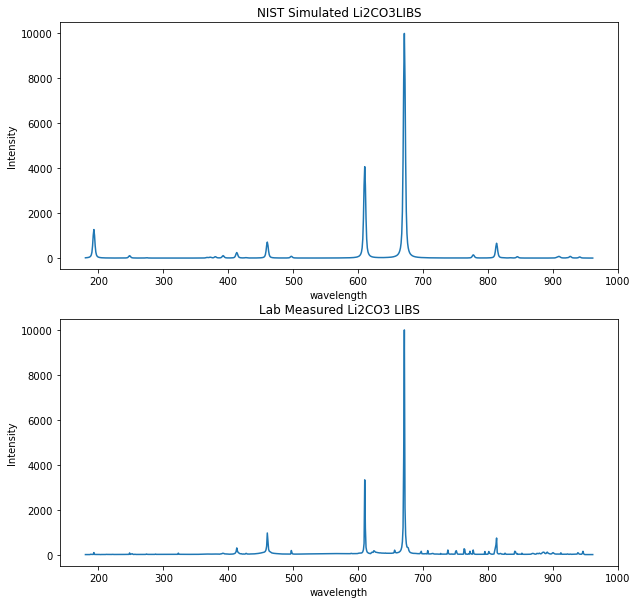

In [122]:
#Compare the nist simulated Li2CO3 spectrum to experimental to understand failure to predict C, O
fig, ax = plt.subplots(2,1, figsize=(10,10)) 
ax[0].set_xlabel('wavelength')  # Add an x-label to the axes.
ax[0].set_ylabel('Intensity')  # Add a y-label to the axes.
ax[0].set_title('NIST Simulated Li2CO3LIBS')  # Add a title to the axes.
ax[0].plot(wave, nist_li2co3_std)
ax[1].set_xlabel('wavelength')  # Add an x-label to the axes.
ax[1].set_ylabel('Intensity')  # Add a y-label to the axes.
ax[1].set_title('Lab Measured Li2CO3 LIBS')  # Add a title to the axes.
ax[1].plot(wave, x_spec)

<function matplotlib.pyplot.show(close=None, block=None)>

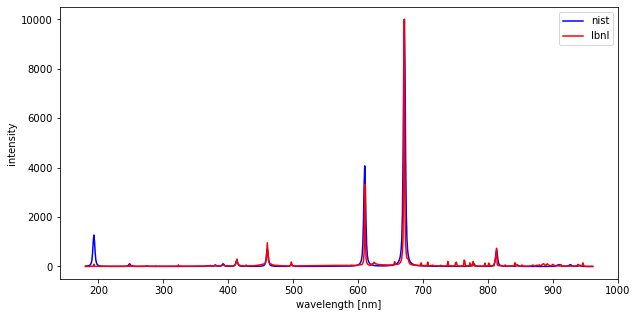

In [123]:
#Plot them on one graph in different colors to compare
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(wave, nist_li2co3_std, color='blue', label = 'nist') 
plt.plot(wave, x_spec, color='red', label='lbnl')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.legend()
plt.show

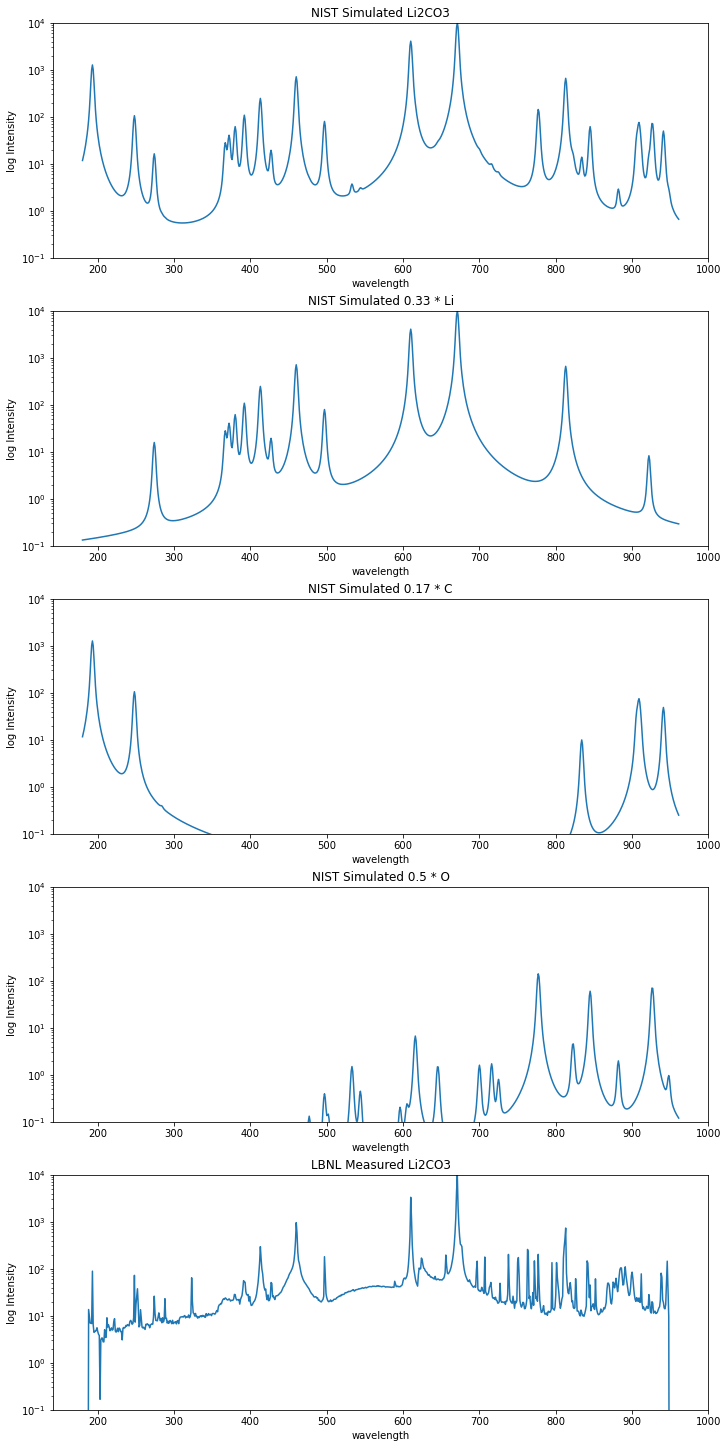

In [129]:
#Note spec_maker also returns the element spectra from the weighted lines given to make_spectra
#examine composites and pieces on the log scale seen by model y-axes consistently scaled
fig, ax = plt.subplots(5,1, figsize=(10,20), constrained_layout=True) 
[ax[i].set_xlabel('wavelength') for i in range(5)] # Add an x-label to the axes.
[ax[i].set_ylabel('log Intensity') for i in range(5)] # Add a y-label to the axes.
[ax[i].set_ylim(0.1,1e4) for i in range(5)] # consistent range on y-axis.
[ax[i].set_yscale('log') for i in range(5)] # log scaling of axis
ax[0].set_title('NIST Simulated Li2CO3')  # Add a title to the axes.
ax[1].set_title('NIST Simulated 0.33 * Li')
ax[2].set_title('NIST Simulated 0.17 * C')
ax[3].set_title('NIST Simulated 0.5 * O')
ax[4].set_title('LBNL Measured Li2CO3')
ax[0].plot(wave, nist_mult * spec_dict['comp']+ eps)
ax[1].plot(wave, nist_mult * spec_dict['Li'] + eps)
ax[2].plot(wave, nist_mult * spec_dict['C'] + eps)
ax[3].plot(wave, nist_mult * spec_dict['O'] + eps)
ax[4].plot(wave, x_spec + eps)


https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html#sphx-glr-auto-examples-multioutput-plot-classifier-chain-yeast-py

Look another variation of multilabel which does not assume independence